<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Дополнительно" data-toc-modified-id="Дополнительно-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Дополнительно</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка данных

In [1]:
#импортируем необходимые бибиотеки
import warnings
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV,
                                    RandomizedSearchCV,
                                    TimeSeriesSplit)
from sklearn.metrics import make_scorer

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller

In [2]:
#прочитаем данные 
pth1 = '/datasets/taxi.csv'

data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])

In [3]:
data.sort_index(inplace=True) 
data = data.resample('1H').sum() #ресемплирование по часу

## Анализ данных

Проверим данные на монотонность, чтобы убедиться, что данные в расположены в порядке возрастания. Также выведем основную информацию и график количества заказов по часам

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


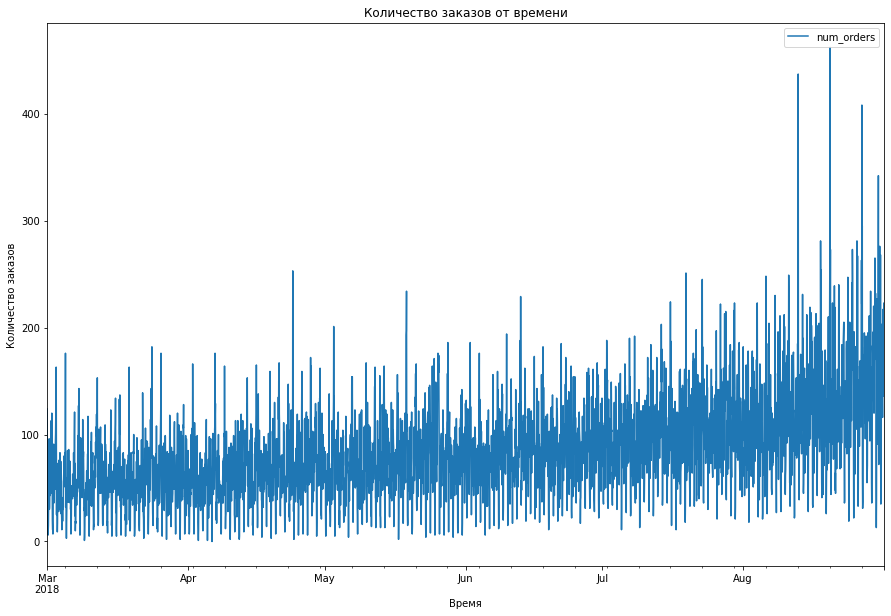

In [4]:
print(data.index.is_monotonic)
print(data.info())

data.plot(figsize = (15,10), title = 'Количество заказов от времени', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()

Видно, что летом начинается спрос, среднее количество заказов увеличивается, а также в августе наблюдается более сильный разброс, видно, что есть часы, когда заказов было гораздо больше, чем когда-либо за данный промежуток

Также декомпозируем данные, посмотрим наличие сезонности и тренда

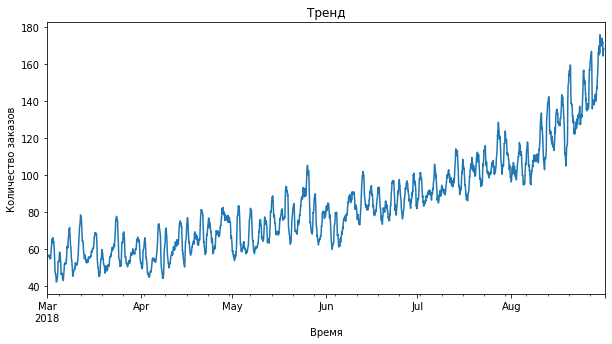

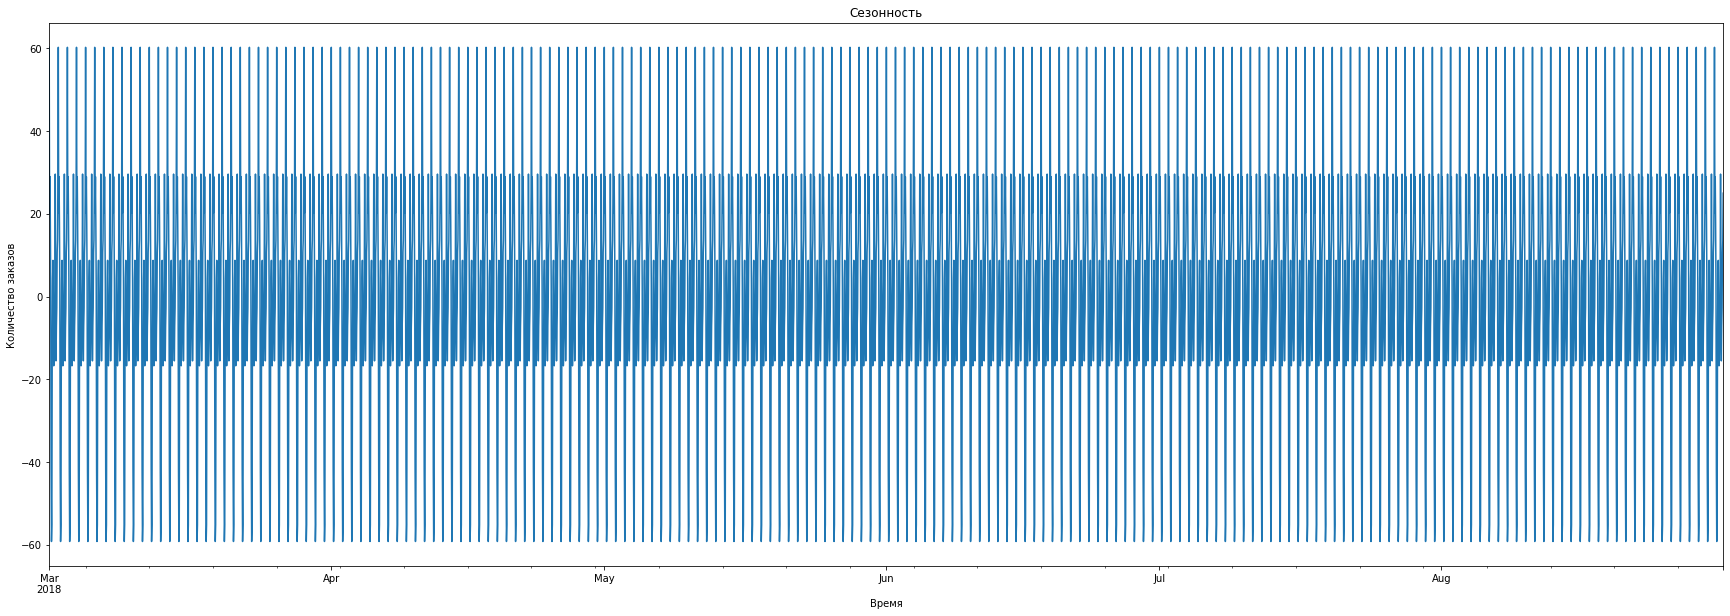

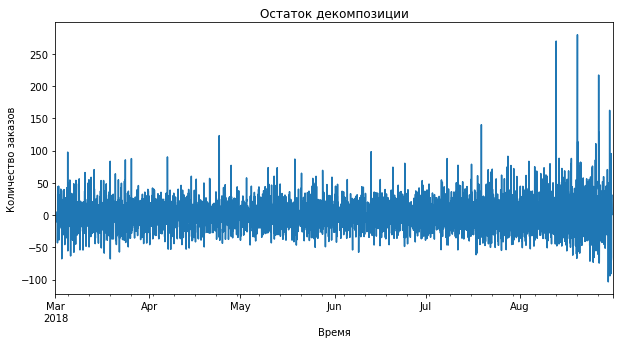

In [5]:
decomposed = seasonal_decompose(data)

decomposed.trend.plot(figsize = (10,5), title = 'Тренд', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()
decomposed.seasonal.plot(figsize = (30,10), title = 'Сезонность', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()
decomposed.resid.plot(figsize = (10,5), title = 'Остаток декомпозиции', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()

Данные получены за 5 месяцев, видно, что наблюдается постепенное увеличение количество заказов летом

Посмотрим сезонность за более короткий период времени. Сначала посмотрим за месяц, за неделю, а потом за несколько дней

In [6]:
data_apr = data['2018-04-01':'2018-04-30'].copy()

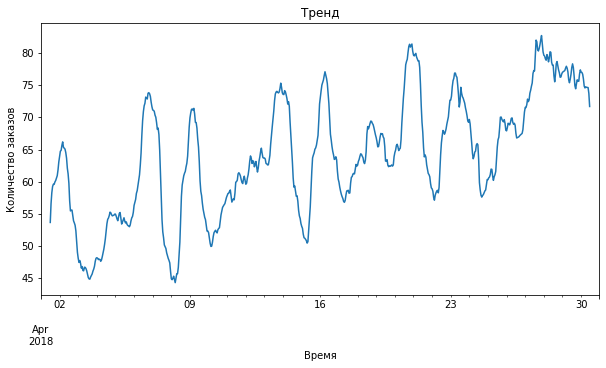

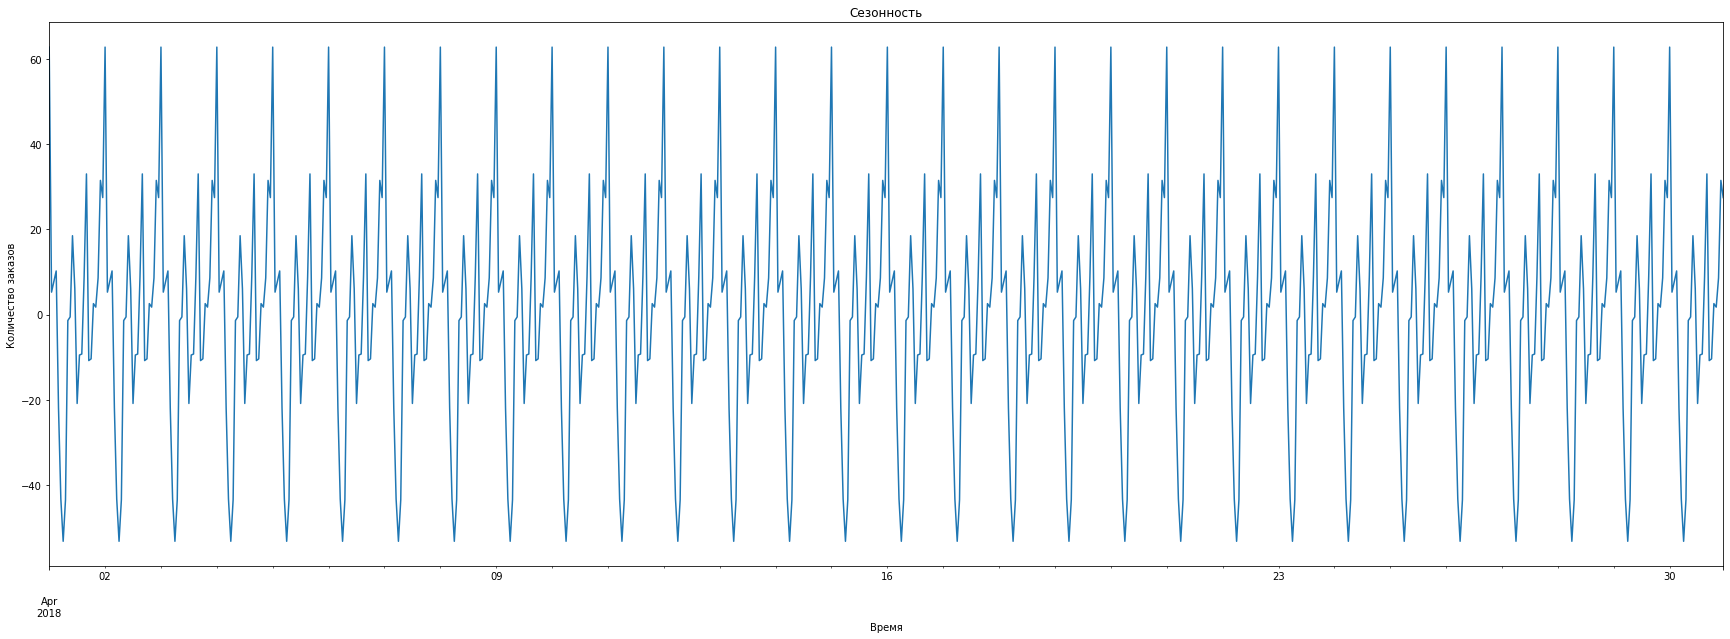

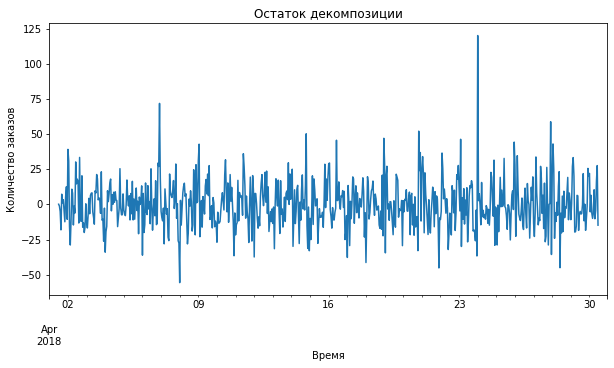

In [7]:
decomposed = seasonal_decompose(data_apr)

decomposed.trend.plot(figsize = (10,5), title = 'Тренд', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()
decomposed.seasonal.plot(figsize = (30,10), title = 'Сезонность', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()
decomposed.resid.plot(figsize = (10,5), title = 'Остаток декомпозиции', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()

In [8]:
data_apr['rolling_mean'] = data_apr.shift().rolling(9).mean() 

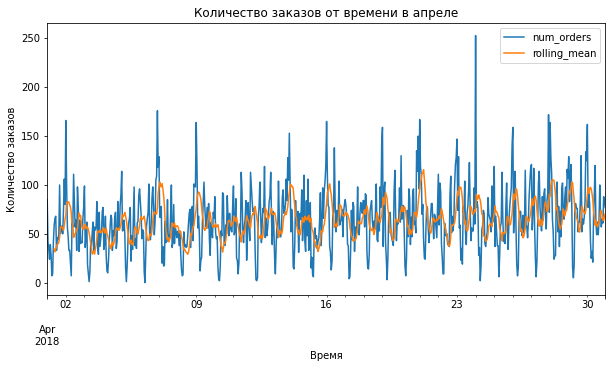

In [9]:
warnings.filterwarnings("ignore") 
data_apr.plot(figsize = (10,5), title = 'Количество заказов от времени в апреле', xlabel = 'Время', ylabel = 'Количество заказов');

Данный временной ряд нестационарный

Посмотрим детальнее: выберем неделю

In [10]:
data_apr_week = data['2018-04-16':'2018-04-22'].copy()



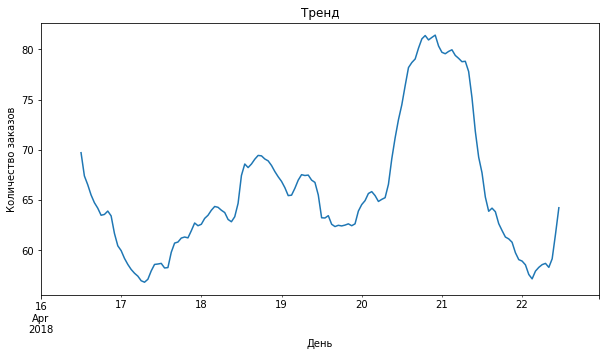

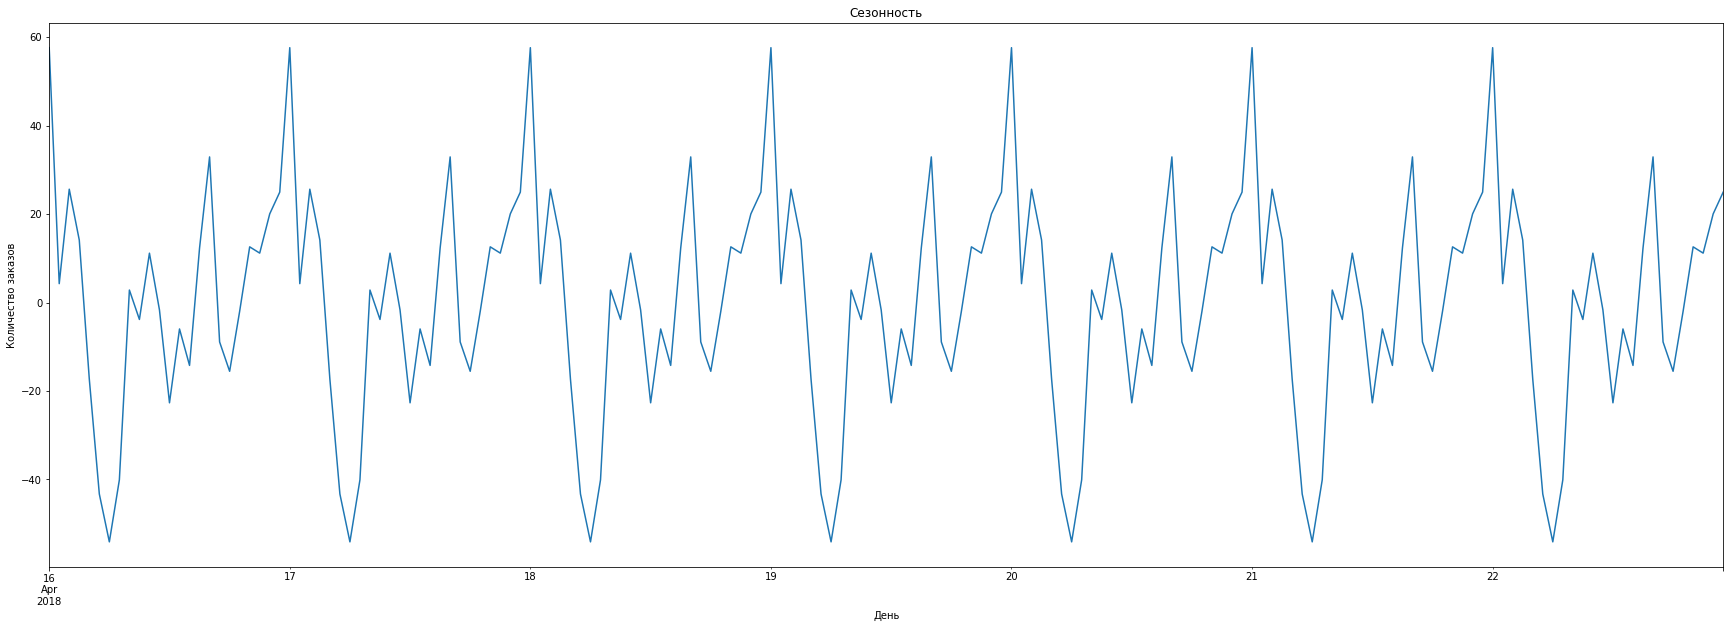

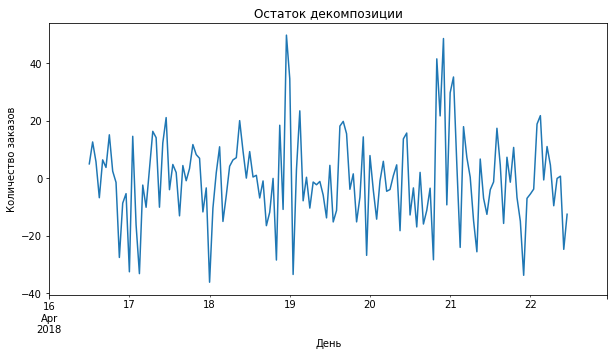

In [11]:
decomposed = seasonal_decompose(data_apr_week)

decomposed.trend.plot(figsize = (10,5), title = 'Тренд', xlabel = 'День', ylabel = 'Количество заказов')
plt.show()
decomposed.seasonal.plot(figsize = (30,10), title = 'Сезонность', xlabel = 'День', ylabel = 'Количество заказов')
plt.show()
decomposed.resid.plot(figsize = (10,5), title = 'Остаток декомпозиции', xlabel = 'День', ylabel = 'Количество заказов')
plt.show()

Видно, что наблюдается повторяющаяся сезонность каждый день. 

Посмотрим на несколько дней

In [12]:
data_apr_week_day = data['2018-04-19':'2018-04-21'].copy()

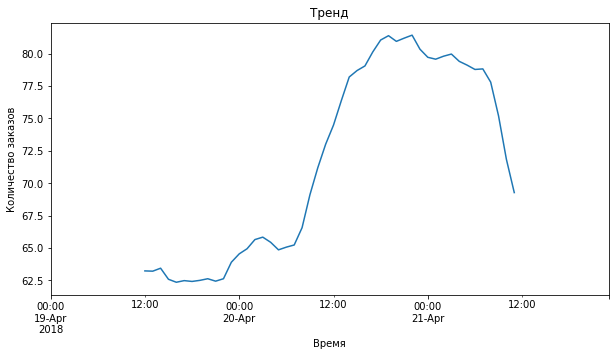

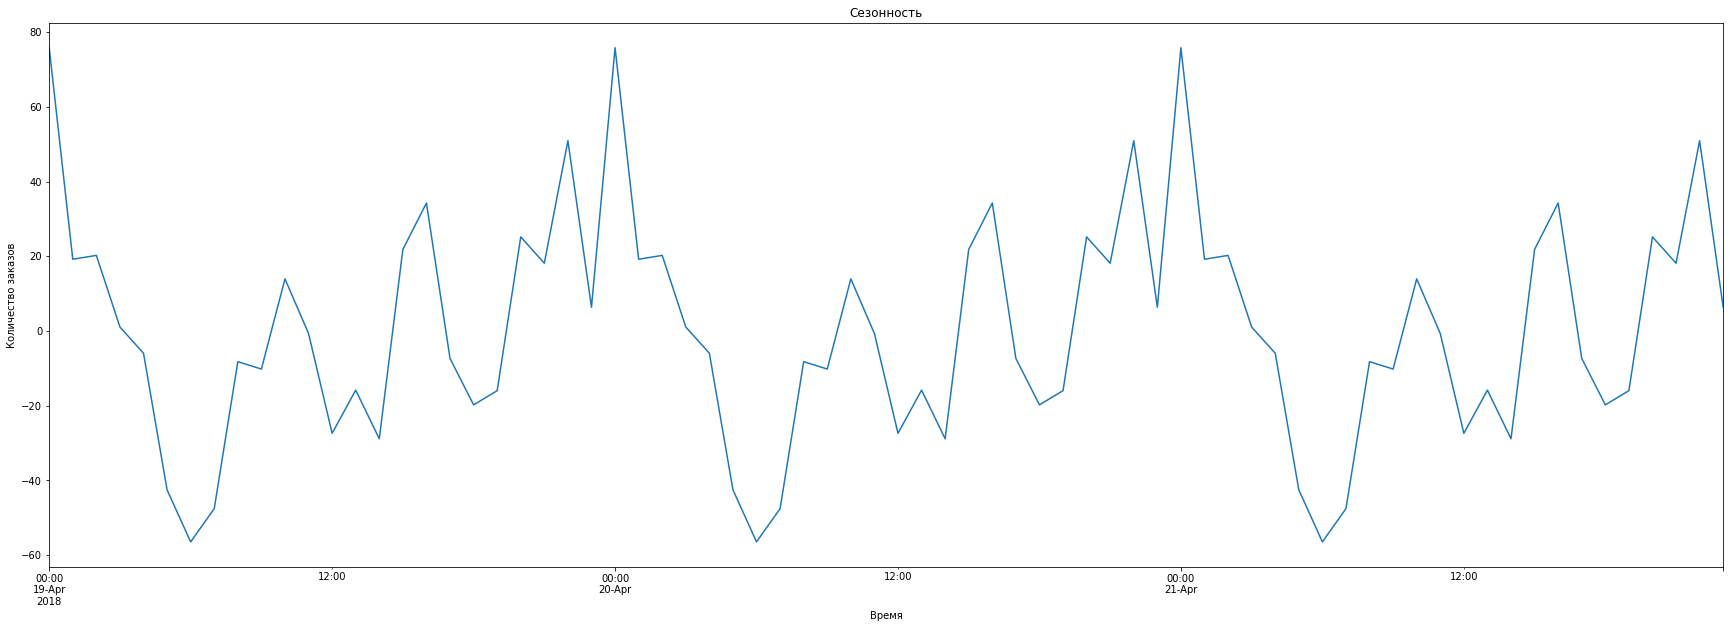

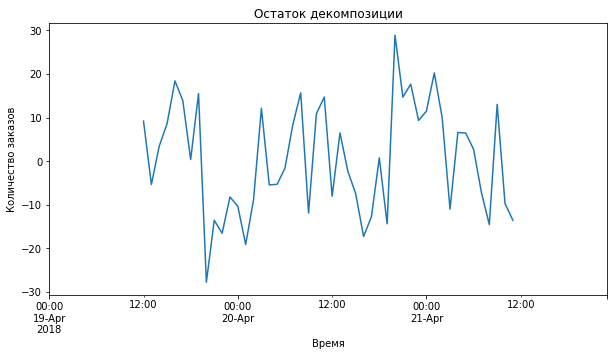

In [13]:
decomposed = seasonal_decompose(data_apr_week_day)

decomposed.trend.plot(figsize = (10,5), title = 'Тренд', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()
decomposed.seasonal.plot(figsize = (30,10), title = 'Сезонность', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()
decomposed.resid.plot(figsize = (10,5), title = 'Остаток декомпозиции', xlabel = 'Время', ylabel = 'Количество заказов')
plt.show()

Видно, что природа сезонности суточная, наибольшее количество заказов в 0:00, вероятно, потому что другой транспорт уже плохо ходит. Также видим, что заказы скчкообразны, скорее всего это связано с тем, что у самолетов определенное расписание. Спад заказов наблюдается как правило в 6 утра.


**Проведем тест Дики-Фуллера для проверки на стационарность ряда**

0 гипотеза: ряд нестационарный

1 гипотеза: ряд стационарный

In [14]:
result = adfuller(data['num_orders'], autolag = 'AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] > result[4][key]:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

    else:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
Нулевая гипотеза не отвергнута – Временной ряд не стационарен
	5%: -2.862
Нулевая гипотеза отвергнута – Временной ряд стационарен
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


## Подготовка данных

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    """
    Функция создает новые столбцы в датафрейме, такие как год, месяц, день, день недели, отстающие значения и скользящее среднее
    
    Параметры:
        data  - датасет;
        max_lag - параметр, показыающий на сколько отстает значение;
        rolling_mean_size - аргумент, который задает ширину окна для вычисления скользящего среднего.
    """
    data_make_features = data.copy()
    data_make_features['day'] = data_make_features.index.day
    data_make_features['dayofweek'] = data_make_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_make_features['lag_{}'.format(lag)] = data_make_features['num_orders'].shift(lag)

    data_make_features['rolling_mean'] = data_make_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_make_features

In [45]:
#применим функцию
data_new = make_features(data, 30, 2)

Разделение данных на выборки:

In [46]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1, random_state=42)

train = train.dropna()
                
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

## Обучение моделей

 - Бустинг LGBM

In [53]:
model = LGBMRegressor(random_state = 42)

params = {'n_estimators': range (80, 201, 20), 
          'learning_rate': [0.001, 0.01, 0.05, 0.1],
          'max_depth': [None] + [i for i in range(2, 7)]} 

In [54]:
tscv = TimeSeriesSplit(n_splits=5)

grid_1 = GridSearchCV(model, params, scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),n_jobs=-1, cv=tscv)

In [55]:
grid_1.fit(X_train, y_train)

print(grid_1.best_params_)
print('Качество модели LighGBM:', -grid_1.best_score_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 140}
Качество модели LighGBM: 25.232333553653312


 - Линейная регрессия

In [52]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

model = LinearRegression()


params = {'fit_intercept':[True, False],
            'copy_X':[True, False]} 

grid_2 = GridSearchCV(model, params, scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),n_jobs=-1, cv=tscv)
grid_2.fit(X_train, y_train)

print(grid_2.best_params_)

print('Качество модели линейной регрессии:', -grid_2.best_score_)


{'copy_X': True, 'fit_intercept': False}
Качество модели линейной регрессии: 26.774924583882296
CPU times: user 1.47 s, sys: 2.24 s, total: 3.71 s
Wall time: 3.65 s


 - Случайный лес

In [47]:
%%time 
warnings.filterwarnings("ignore") 

tscv = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor(random_state = 42)

params = {'n_estimators': range (80, 201, 40),
          'max_depth': [None] + [i for i in range(2, 7)]} 

CPU times: user 88 µs, sys: 1 µs, total: 89 µs
Wall time: 91.6 µs


In [48]:
grid_0 = GridSearchCV(model, params, scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),n_jobs=-1, cv=tscv)
grid_0.fit(X_train, y_train)

print(grid_0.best_params_)
print(-grid_0.best_score_)

{'max_depth': None, 'n_estimators': 200}
25.55780218959169



 
Таким образом при max_lag = 30   и rolling_mean_size = 2 на кросс-валидации модели показали следующие результаты:

 - Бустинг LGBM: 25.2
 - Линейная регрессия: 26.8
 - Случайный лес: 25,5
 
Для тестирования выберем лучшую модель: случайный лес

## Тестирование модели

Построим также константную модель, чтобы оценить вышепостроенные модели

In [49]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

dummy_predictions_test = dummy_regr.predict(X_test)

rmse = mean_squared_error(y_test, dummy_predictions_test) ** 0.5
print('Значение метрики RMSE на тестовой выборке для dummy модели:', rmse)

Значение метрики RMSE на тестовой выборке для dummy модели: 84.63336276399527


Значит, есть смысл использовать более сложные модели

In [50]:
# Предскажем результаты на тестовой выборке
predictions_test = grid_0.best_estimator_.predict(X_test)

In [51]:
rmse = mean_squared_error(y_test, predictions_test) ** 0.5
print('Значение метрики RMSE на тестовой выборке:', rmse)

Значение метрики RMSE на тестовой выборке: 42.943740907008035


In [56]:
#создание датафрейма для графика

preds = pd.DataFrame(predictions_test) 
y_test = pd.DataFrame(np.array(y_test), index = preds.index)

df = pd.concat([preds, y_test], axis= 1 )
df.columns = ['preds', 'y_test']

df.reset_index(inplace= True )
df

,index,preds,y_test
0,0,105.100,102
1,1,133.905,175
2,2,147.795,144
3,3,127.510,152
4,4,87.700,104
...,...,...,...
437,437,128.155,136
438,438,168.160,154
439,439,161.050,159
440,440,161.295,223


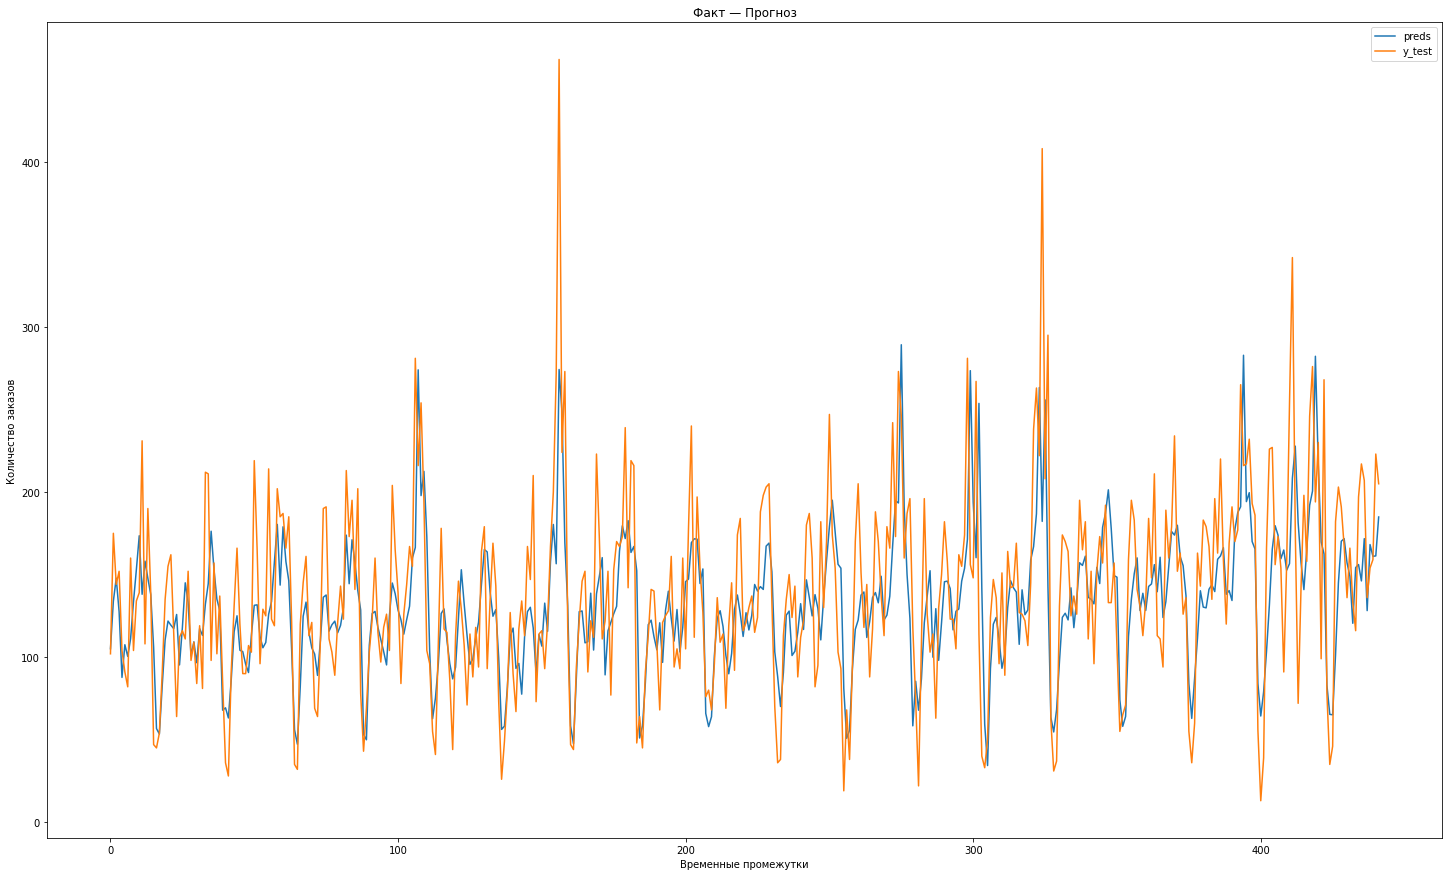

In [57]:
df[['index','preds', 'y_test']].plot(x='index', figsize = (25,15), title = 'Факт — Прогноз', xlabel = 'Временные промежутки', ylabel = 'Количество заказов') 
plt.show()

**Вывод по графику**

Видно, что предсказания имеют не такую "амплитуду" и иногда не достают до реальных значений, но тенденция правильная, совпадают возрастающие и убывающие участки. Модель подстроилась под определенные периоды и более сильные скачки не может предсказать.

## Вывод

В данной работе были проанализированы временные данные для компании "Четенькое такси". Данные были о количестве заказов около аэропорта. Необходимо придумать решение для наиболее правильного прогнозирования количества заказов.

Данные были обработаны и были построены модели, где учитывалась метрика rmse. Лучшей моделью оказался случайный лес, который в дальнейшем и был протестирован. Таким образом значение rmse на тестовой выборке составило 42,9 , что выполянет условие задачи, что rmse должно быть меньше 48. Также построен график предсказаний и реальных значений, который показывает, что модель хорошо видит тренд и сезонности.